# Data Preprocessing
In this notebook we are going to download the dataset from kaggle, to preprocess it and to split it in train, validation and test set.

# Import, costants and installations
In order to perform the preprocessing we need to install some extra libraries.

In [1]:
!pip install nlpaug
!pip install transformers
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 410 kB 6.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 8.1 MB/s 
     |████████████████████████████████| 596 kB 51.7 MB/s 
     |████████████████████████████████| 6.6 MB 47.8 MB/s 
     |████████████████████████████████| 101 kB 3.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 197 kB 5.5 MB/s 
  Created wheel for emoji: filename=emoji-2.0.0-py3-none-any.whl size=193022 sha256=85547235a8e1d22eca9a22ffaccdc07e126a013e3019819628fa20e75d5720d1
  Stored in directory: /root/.cache/pip/wheels/ec/29/4d/3cfe7

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
import os
import shutil
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from google.colab import drive 
import re, string
import emoji
import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import nlpaug.augmenter.word as naw
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.7/dist-packages/resampy/interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  _resample_loop_p(x, t_out, interp_win, interp_delta, num_table, scale, y)


# Connection to Google Drive

In [3]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# Utilities
We load the notebook where we defined some utility functions.

In [4]:
%run /content/gdrive/Shareddrives/CyberBullyingClassification/utilities.ipynb

The function below will show the distribution of classes inside a DataFrame.

In [5]:
def plot_distribution(df):
  counts = df['cyberbullying_type'].value_counts()
  print(counts)
  ax = counts.plot.bar()

# Download of the dataset

We install kaggle, upload the json token provided by the platform and perform the local download of the dataset.

In [6]:
! pip install -q kaggle

from google.colab import files
_ = files.upload()

! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [7]:
%%capture
! kaggle datasets download -d andrewmvd/cyberbullying-classification
! unzip cyberbullying-classification.zip -d cyberbullying-classification
! rm cyberbullying-classification.zip

Now we are going to read the dataset from the CSV file.

In [8]:
df = pd.read_csv('/content/cyberbullying-classification/cyberbullying_tweets.csv')

We show the distribution of the datas.

Inside the DataFrame object we can see some examples of tweet with their labels.

In [9]:
df

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity


religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64


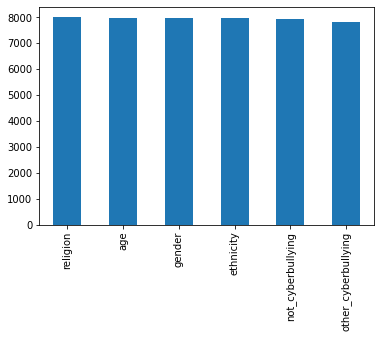

In [10]:
plot_distribution(df)

As we can see the dataset without any preprocessing is almost balanced.

# Data Preprocess
In this chapter we are going to perform preprocessing on our dataset.

In order to do so we need to define the english languages to recognise stop words.

In [11]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


We define some functions in order to clean the text of the tweets.

In [12]:
#Clean emojis from text
def strip_emoji(text):
    return emoji.replace_emoji(text, replace='')

#Remove punctuations, links, stopwords, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
    text =' '.join(word for word in text.split() if len(word) < 14) # remove words longer than 14 characters
    return text

#remove contractions
def decontract(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the "#" symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as "&" and "$" present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

#Remove multiple sequential spaces
def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

#Stemming
def stemmer(text):
    tokenized = nltk.word_tokenize(text)
    ps = PorterStemmer()
    return ' '.join([ps.stem(words) for words in tokenized])

#Then we apply all the defined functions in the following order
def deep_clean(text):
    text = strip_emoji(text)
    text = decontract(text)
    text = strip_all_entities(text)
    text = clean_hashtags(text)
    text = filter_chars(text)
    text = remove_mult_spaces(text)
    return text

We apply these functions to our dataset.

In [13]:
texts_new = []
for t in df.tweet_text:
    texts_new.append(deep_clean(t))

df['tweet_clean'] = texts_new

df

,tweet_text,cyberbullying_type,tweet_clean
0,"In other words #katandandre, your food was cra...",not_cyberbullying,words katandandre food crapilicious mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white mkr theblock today sunrise stud...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classy whore red velvet cupcakes
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh p thanks heads concerned another angry dud...
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isis account pretending kurdish account like i...
...,...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity,black ppl expected anything depended anything ...
47688,Turner did not withhold his disappointment. Tu...,ethnicity,turner withhold turner called court abominable...
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity,swear god dumb nigger bitch got bleach hair re...
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity,yea fuck rt youre nigger fucking unfollow fuck...


After the preprocessing it is possible that some tweets become equal. Since they bias our dataset we are not interested in keeping them and we will remove them.

In [14]:
df["tweet_clean"].duplicated().sum()

3034

In [15]:
df.drop_duplicates("tweet_clean", inplace=True)

We remove tweets with length < 3, since they are too short to be considered relevant for our analisys.

In [16]:
text_len = []
for text in df.tweet_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [17]:
df["tweet_len"] = text_len
df = df[df["tweet_len"] > 3]

In [18]:
df

,tweet_text,cyberbullying_type,tweet_clean,tweet_len
0,"In other words #katandandre, your food was cra...",not_cyberbullying,words katandandre food crapilicious mkr,5
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white mkr theblock today sunrise stud...,10
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classy whore red velvet cupcakes,5
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh p thanks heads concerned another angry dud...,9
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isis account pretending kurdish account like i...,8
...,...,...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity,black ppl expected anything depended anything ...,21
47688,Turner did not withhold his disappointment. Tu...,ethnicity,turner withhold turner called court abominable...,28
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity,swear god dumb nigger bitch got bleach hair re...,13
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity,yea fuck rt youre nigger fucking unfollow fuck...,10


religion               7894
age                    7839
ethnicity              7713
gender                 7316
not_cyberbullying      6368
other_cyberbullying    4669
Name: cyberbullying_type, dtype: int64


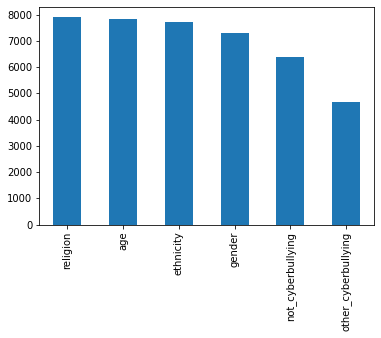

In [19]:
plot_distribution(df)

# Splitting the dataset
We decided to split the dataset with the percentage of 0.6 for the training set, 0.2 for the validation set and 0.2 for the test set.

In [20]:
train_ds, test_ds = train_test_split(df, test_size=0.2)

religion               6309
age                    6279
ethnicity              6143
gender                 5875
not_cyberbullying      5138
other_cyberbullying    3695
Name: cyberbullying_type, dtype: int64


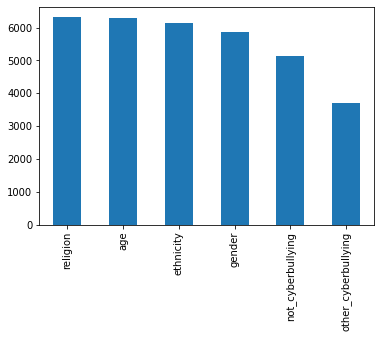

In [22]:
plot_distribution(train_ds)

religion               1585
ethnicity              1570
age                    1560
gender                 1441
not_cyberbullying      1230
other_cyberbullying     974
Name: cyberbullying_type, dtype: int64


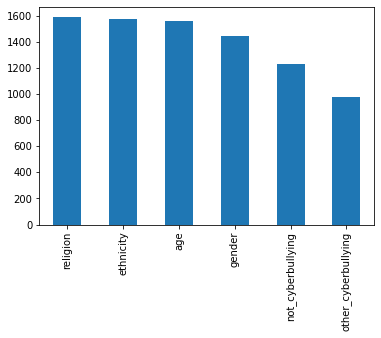

In [23]:
plot_distribution(test_ds)

# Data Augmentation
As we can see after the duplicate removal the classes are unbalanced. In particular there are a lot less tweets belonging to the other_cyberbullying class. This could be a problem for our training set, since performing the training on an unbalanced set could give use some problems. We are gonna perform data augmentation on the train set in order to keep the dataset balanced. 

We will use a library that will add synonyms to the texts.

In [24]:
def augment_text(text):
  aug = naw.SynonymAug(aug_src='wordnet',aug_min=1,aug_max=2)
  text = aug.augment(text)
  return text

An example of transformation is shown below.

In [25]:
text_sentence = df['tweet_clean'].sample(ignore_index = True)[0]

text_sentence_aug = augment_text(text_sentence)
print(text_sentence)
print(deep_clean(text_sentence_aug[0]))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


boy snapchat calling black girl nigger saying disgusting things
male child snapchat calling black little girl nigger saying disgusting things


In [26]:
max_dim_class = train_ds['cyberbullying_type'].value_counts()[0] #check the class with the max number of element

augmented_texts = []
tweet_texts = []
labels = []

for label in CLASSES:
  dim_class = train_ds['cyberbullying_type'].value_counts()[label]
  df_class = train_ds.query("cyberbullying_type == \'" + label +  "\'")

  for i in tqdm(range(0, max_dim_class - dim_class)): # we aim to obtain a dataset where each class has max_dim_class elements
    length = 0
    while length < 10:
      row = train_ds.sample(ignore_index=True)
      tweet_text = row['tweet_text'][0]
      text_to_augment = row['tweet_clean'][0]
      length = row['tweet_len'][0]
    augmented_texts.append(deep_clean(augment_text(text_to_augment)))
    tweet_texts.append(tweet_text)
    labels.append(label)

df2 = pd.DataFrame({'tweet_text': tweet_texts, 'tweet_clean': augmented_texts, 'cyberbullying_type': labels})
train_ds = train_ds.append(df2, ignore_index=True)
print(train_ds)

100%|██████████| 434/434 [00:01<00:00, 304.90it/s]
0it [00:00, ?it/s]
100%|██████████| 1171/1171 [00:03<00:00, 327.78it/s]

                                              tweet_text cyberbullying_type  \
0      Zakula I had hoped that maybe there was a brai...           religion   
1      RT @joe_nuzz: Why Our President Chose to Insul...           religion   
2      First off we know the press has lied. Second, ...          ethnicity   
3      @ilhamfauzie lg on gk ya ? Sabar aja ya kl lg ...  not_cyberbullying   
4      'pls vote for us for making u line up for 45mi...  not_cyberbullying   
...                                                  ...                ...   
37849  I came from Pakistan where people joke about r...  not_cyberbullying   
37850  People who get offended by Ebola/gay/rape JOKE...  not_cyberbullying   
37851  Pissed off the cracka called me a dumb nigger ...  not_cyberbullying   
37852  didn't you muted me??? oh well... besides what...  not_cyberbullying   
37853  Entree worth a 3 max. My kids cook better than...  not_cyberbullying   

                                             tweet_

We plot the new balanced data distribuition.

religion               6309
ethnicity              6309
not_cyberbullying      6309
age                    6309
gender                 6309
other_cyberbullying    6309
Name: cyberbullying_type, dtype: int64


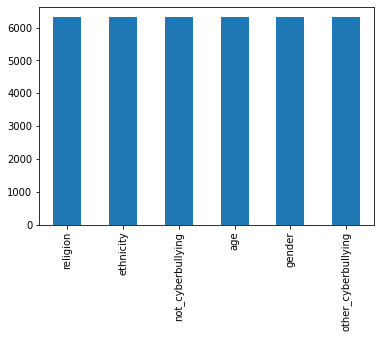

In [27]:
plot_distribution(train_ds)

Then we need to apply stemmization to our dataset.

In [28]:
texts_new = []
for t in train_ds.tweet_clean:
    texts_new.append(stemmer(t))

train_ds['tweet_clean'] = texts_new

texts_new = []
for t in test_ds.tweet_clean:
    texts_new.append(stemmer(t))

test_ds['tweet_clean'] = texts_new

In [29]:
print(train_ds)

                                              tweet_text cyberbullying_type  \
0      Zakula I had hoped that maybe there was a brai...           religion   
1      RT @joe_nuzz: Why Our President Chose to Insul...           religion   
2      First off we know the press has lied. Second, ...          ethnicity   
3      @ilhamfauzie lg on gk ya ? Sabar aja ya kl lg ...  not_cyberbullying   
4      'pls vote for us for making u line up for 45mi...  not_cyberbullying   
...                                                  ...                ...   
37849  I came from Pakistan where people joke about r...  not_cyberbullying   
37850  People who get offended by Ebola/gay/rape JOKE...  not_cyberbullying   
37851  Pissed off the cracka called me a dumb nigger ...  not_cyberbullying   
37852  didn't you muted me??? oh well... besides what...  not_cyberbullying   
37853  Entree worth a 3 max. My kids cook better than...  not_cyberbullying   

                                             tweet_

Now we eliminate the new duplicates generated with the last two operations.

In [30]:
print(train_ds["tweet_clean"].duplicated().sum())
train_ds.drop_duplicates("tweet_clean", inplace=True)

669


In [31]:
print(test_ds["tweet_clean"].duplicated().sum())
test_ds.drop_duplicates("tweet_clean", inplace=True)

0


Add tweet length for new tweets.

In [32]:
text_len = []
for text in train_ds.tweet_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

text_len = []
for text in test_ds.tweet_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [33]:
train_ds

,tweet_text,cyberbullying_type,tweet_clean,tweet_len
0,Zakula I had hoped that maybe there was a brai...,religion,zakula hope mayb brain head mistaken bad say t...,22.0
1,RT @joe_nuzz: Why Our President Chose to Insul...,religion,rt presid chose insult christian excus milit i...,11.0
2,"First off we know the press has lied. Second, ...",ethnicity,first know press lie second protest fine loote...,24.0
3,@ilhamfauzie lg on gk ya ? Sabar aja ya kl lg ...,not_cyberbullying,lg gk ya sabar aja ya kl lg di bulli tp hrz tt...,22.0
4,'pls vote for us for making u line up for 45mi...,not_cyberbullying,pl vote us make u line 45min mkr,8.0
...,...,...,...,...
37849,I came from Pakistan where people joke about r...,not_cyberbullying,came pakistan peopl joke brassica napu gay mis...,NaN
37850,People who get offended by Ebola/gay/rape JOKE...,not_cyberbullying,peopl fix offend ebolagayrap joke need calm fu...,NaN
37851,Pissed off the cracka called me a dumb nigger ...,not_cyberbullying,piss cracka call dumb spade tri bump damn big ...,NaN
37852,didn't you muted me??? oh well... besides what...,not_cyberbullying,mute oh well besid anyth chri parti even drug ...,NaN


religion               6308
age                    6304
ethnicity              6284
gender                 6233
not_cyberbullying      6147
other_cyberbullying    5909
Name: cyberbullying_type, dtype: int64


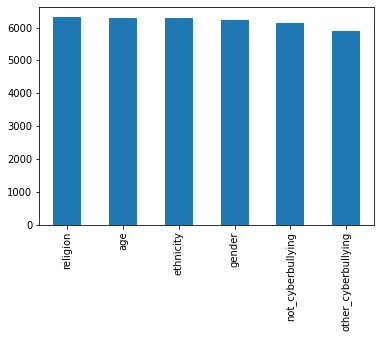

In [34]:
plot_distribution(train_ds)

Despite the duplicates removal the dataset is almost perfectly balanced, so other operations are not necessary.

# Dataset storing
We decided to split the dataset with the percentage of 0.6 for the training set, 0.2 for the validation set and 0.2 for the test set. So it remains to create the validation set from the augmented training set.

In [35]:
train_ds, val_ds = train_test_split(train_ds, test_size=0.25) # 0.8 * 0.25 = 0.2 

We save the datasets as pickle files on the Drive in order to retrieve them in the other notebooks.

In [36]:
saveObject(df, SETS_DIR + '/dataset')

saveObject(train_ds, SETS_DIR + '/train')
saveObject(val_ds, SETS_DIR + '/val')
saveObject(test_ds, SETS_DIR + '/test')

Saving /content/gdrive/Shareddrives/CyberBullyingClassification/cyberbullying-classification-splits/dataset.pkl
Saving /content/gdrive/Shareddrives/CyberBullyingClassification/cyberbullying-classification-splits/train.pkl
Saving /content/gdrive/Shareddrives/CyberBullyingClassification/cyberbullying-classification-splits/val.pkl
Saving /content/gdrive/Shareddrives/CyberBullyingClassification/cyberbullying-classification-splits/test.pkl


age                    4736
gender                 4729
religion               4729
ethnicity              4662
not_cyberbullying      4592
other_cyberbullying    4440
Name: cyberbullying_type, dtype: int64


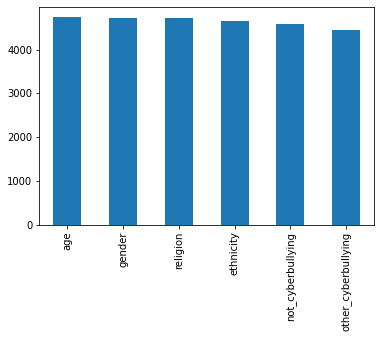

In [38]:
plot_distribution(train_ds)

ethnicity              1622
religion               1579
age                    1568
not_cyberbullying      1555
gender                 1504
other_cyberbullying    1469
Name: cyberbullying_type, dtype: int64


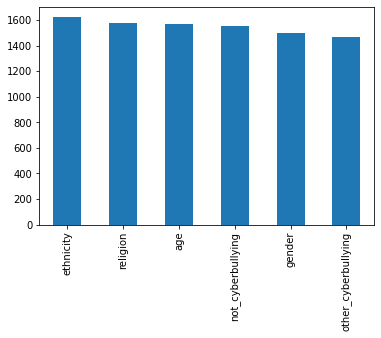

In [39]:
plot_distribution(val_ds)

religion               1585
ethnicity              1570
age                    1560
gender                 1441
not_cyberbullying      1230
other_cyberbullying     974
Name: cyberbullying_type, dtype: int64


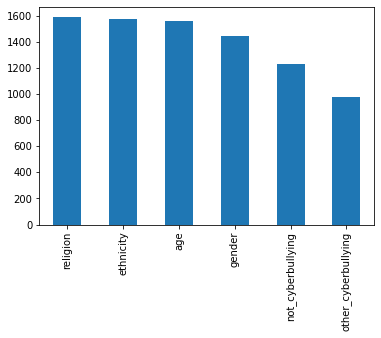

In [40]:
plot_distribution(test_ds)